In [1]:
!pip install netCDF4 --q

#!pip install wandb -qU

In [2]:
import netCDF4 as nc
from netCDF4 import Dataset
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import numpy as np
import pandas
import matplotlib as plt

In [3]:
data = nc.Dataset('/content/test1hr.nc')

rain_data = data["precip_liquid"]
rain_data = rain_data[:,[28],0,[17]]

wind_data = data['uvel']
wind_data = wind_data[:,[28],0,[17]]

temp_data = data['temp']
temp_data = temp_data[:,[28],0,[17]]

time = data['t']
time = np.asarray(time)

In [4]:
time_train,time_test,precip_train,precip_test  = train_test_split(time,rain_data )
time_train,time_test,uvel_train,uvel_test = train_test_split(time,wind_data)
time_train,time_test,temp_train,temp_test = train_test_split(time,temp_data)

training_data = [time_train, precip_train,uvel_train,temp_train]
testing_data = [time_test, precip_test,uvel_test,temp_test]
data = [time,rain_data, wind_data,temp_data]

In [5]:
scaler = StandardScaler()

nsamples, nx, ny = precip_train.shape
rain_data_norm = precip_train.reshape((nsamples,nx*ny))
#test_norm = precip_test.reshape((nsamples,nx*ny))
wind_data_norm = uvel_train.reshape((nsamples,nx*ny))
temp_data_norm = temp_train.reshape((nsamples,nx*ny))

scaler = scaler.fit(rain_data_norm)

precip_train = scaler.transform(rain_data_norm)
#precip_test = scaler.transform(precip_test)

'''
scaler = MinMaxScaler()
nsamples, nx, ny = precip_train.shape
rain_data_norm = precip_train.reshape((nsamples,nx*ny))
wind_data_norm = uvel_train.reshape((nsamples,nx*ny))
temp_data_norm = temp_train.reshape((nsamples,nx*ny))

rain_data_norm = scaler.fit_transform(rain_data_norm)
wind_data_norm = scaler.fit_transform(wind_data_norm)
temp_data_norm = scaler.fit_transform(temp_data_norm)

rain_data_norm = scaler.fit_transform(precip_train)
wind_data_norm = scaler.fit_transform(uvel_train)
temp_data_norm = scaler.fit_transform(temp_train)
'''

'\nscaler = MinMaxScaler()\nnsamples, nx, ny = precip_train.shape\nrain_data_norm = precip_train.reshape((nsamples,nx*ny))\nwind_data_norm = uvel_train.reshape((nsamples,nx*ny))\ntemp_data_norm = temp_train.reshape((nsamples,nx*ny))\n\nrain_data_norm = scaler.fit_transform(rain_data_norm)\nwind_data_norm = scaler.fit_transform(wind_data_norm)\ntemp_data_norm = scaler.fit_transform(temp_data_norm)\n\nrain_data_norm = scaler.fit_transform(precip_train)\nwind_data_norm = scaler.fit_transform(uvel_train)\ntemp_data_norm = scaler.fit_transform(temp_train)\n'

In [6]:
#https://www.tensorflow.org/tutorials/generative/autoencoder
#TO DO: save best model
from tensorflow.keras.models import Model
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      keras.layers.Flatten(),
      keras.layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      keras.layers.Dense(784, activation='sigmoid'),
      #keras.layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())

In [7]:
print(time_test.shape, time_train.shape, precip_test.shape, precip_train.shape)

(113,) (338,) (113, 1, 1) (338, 1)


In [8]:
autoencoder.fit(time_test, precip_test,
                epochs=1000,
                shuffle=True,
                validation_data=(time_train, precip_train))
#TO DO: only print every 100 epochs

Epoch 1/1000
4/4 [==============================] - 1s 96ms/step - loss: 0.4520 - val_loss: 0.3706
Epoch 2/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.3375 - val_loss: 0.2685
Epoch 3/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.2362 - val_loss: 0.1699
Epoch 4/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.1439 - val_loss: 0.1033
Epoch 5/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0882 - val_loss: 0.0581
Epoch 6/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0470 - val_loss: 0.0357
Epoch 7/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0317 - val_loss: 0.0242
Epoch 8/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0197 - val_loss: 0.0155
Epoch 9/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0135 - val_loss: 0.0109
Epoch 10/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0091 - val_loss: 0.0067
Epoch 11/

In [18]:
print(precip_test.shape)
precip_test = precip_test.reshape(-1,)
print(precip_test.shape)
#a = precip_test
#a = a.reshape(-1,)
#print(a.shape)

(113, 1, 1)
(113,)


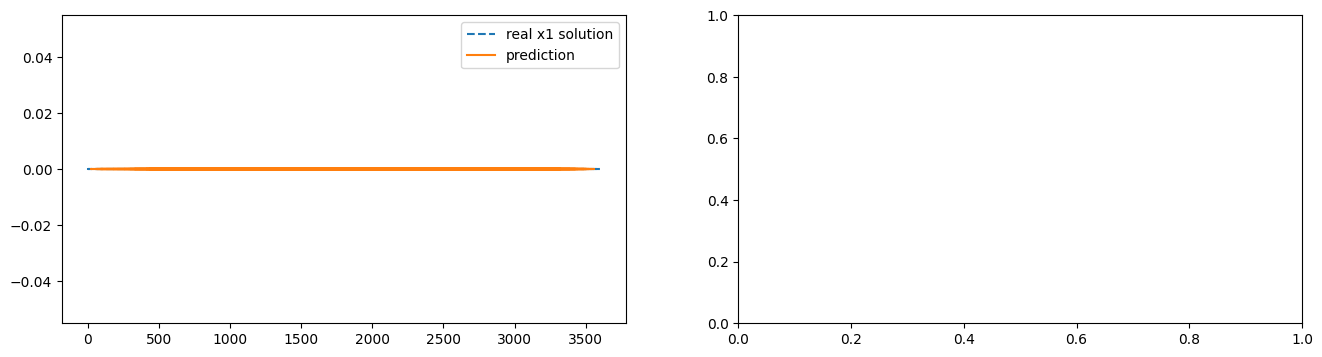

In [19]:
import matplotlib.pyplot as plt
#fig,ax = plt.subplots(1,2,figsize= (16,4))

#ax[0].plot(time_train, precip_train, '--',  time_test, precip_test)
#ax[0].legend(['training','testing'])
#ax[1].plot(t.cpu().numpy(), true_y.detach().numpy()[:, 0, 1], '--', t.cpu().numpy(), best_pred_y.detach().numpy()[:, 0, 1])
#ax[1].legend(['real x2 solution','prediction'])

plt(time_train, precip_train, '--',  time_test, precip_test)